## Import Packages

In [1]:
import pandas as pd
from statsmodels import regression
import statsmodels.api as sm
import pyodbc
import random
import warnings
import itertools
import statistics
import operator
import math
import random
import numpy as np
import datetime
import sys
try:
    import pickle as pickle
except ImportError:
    import pickle

from bisect import bisect_right
from collections import defaultdict
from copy import deepcopy
from functools import partial
from itertools import chain
from operator import eq
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
import talib
#import cvxpy as cp
import scipy as sc
from scipy.stats.stats import pearsonr

## DEAP Package Modification

In [2]:
### Collect all the outstanding alpha factors


class HallOfFame(object):
    """The hall of fame contains the best individual that ever lived in the
    population during the evolution. It is lexicographically sorted at all
    time so that the first element of the hall of fame is the individual that
    has the best first fitness value ever seen, according to the weights
    provided to the fitness at creation time.

    The insertion is made so that old individuals have priority on new
    individuals. A single copy of each individual is kept at all time, the
    equivalence between two individuals is made by the operator passed to the
    *similar* argument.

    :param maxsize: The maximum number of individual to keep in the hall of
                    fame.
    :param similar: An equivalence operator between two individuals, optional.
                    It defaults to operator :func:`operator.eq`.

    The class :class:`HallOfFame` provides an interface similar to a list
    (without being one completely). It is possible to retrieve its length, to
    iterate on it forward and backward and to get an item or a slice from it.
    """
    def __init__(self, maxsize, givenfit, similar=eq):
        self.maxsize = maxsize
        self.keys = list()
        self.items = list()
        self.fitness = list()
        self.similar = similar
        self.givenfit = givenfit

    def update(self, population):
        """Update the hall of fame with the *population* by replacing the
        worst individuals in it by the best individuals present in
        *population* (if they are better). The size of the hall of fame is
        kept constant.

        :param population: A list of individual with a fitness attribute to
                           update the hall of fame with.
        """
        cpb = creator.FitnessMax()  #可与其他Individual的Fitness对比的OBJECT
        setattr(cpb, 'wvalues', tuple((self.givenfit, )))

        if len(self) == 0 and self.maxsize != 0 and len(population) > 0:
            # Working on an empty hall of fame is problematic for the
            # "for else"
            self.insert(population[0])

        for ind in population:
            #Note when writing this into another py doc, the 'Data' outght to be changed
            if ind.fitness >= cpb:  #or len(self) < self.maxsize:
                #print('eventually got one great')
                #print(str(ind))

                for hofer in self:
                    # Loop through the hall of fame to check for any
                    # similar individual
                    if self.similar(ind, hofer[0]) or ind.fitness in self.fitness:
                        break
                else:
                    if len(self) >= self.maxsize:
                        self.remove(-1)
                    self.insert(ind)  #1 for positive corr
                # 此处[ind, 1]看似多余，但若修改该算法后可能会用到negative corr的情况

    def insert(self, item):
        """Insert a new individual in the hall of fame using the
        :func:`~bisect.bisect_right` function. The inserted individual is
        inserted on the right side of an equal individual. Inserting a new
        individual in the hall of fame also preserve the hall of fame's order.
        This method **does not** check for the size of the hall of fame, in a
        way that inserting a new individual in a full hall of fame will not
        remove the worst individual to maintain a constant size.

        :param item: The individual with a fitness attribute to insert in the
                     hall of fame.
        """
        item = deepcopy(item)
        i = bisect_right(self.keys, item.fitness)
        self.fitness.append(item.fitness)
        self.items.insert(len(self) - i, [item, item.fitness])
        self.keys.insert(i, item.fitness)

    def remove(self, index):
        """Remove the specified *index* from the hall of fame.

        :param index: An integer giving which item to remove.
        """
        del self.keys[len(self) - (index % len(self) + 1)]
        del self.items[index]

    def clear(self):
        """Clear the hall of fame."""
        del self.items[:]
        del self.keys[:]
        del self.fitness[:]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        return self.items[i]

    def __iter__(self):
        return iter(self.items)

    def __reversed__(self):
        return reversed(self.items)

    def __str__(self):
        return str(self.items)

# Future Testing

## Input Data

In [3]:
data = pd.read_csv('../0-Data/PTA_2017.csv',encoding = "ISO-8859-1")

In [4]:
data = data[0:271460] # 取三年的数据

In [5]:
ret = ((data['close'] - data['close'].shift(1))/data['close'].shift(1)).fillna(0)
data['return'] = ret.shift(-1).fillna(0) #预测后一时间return

In [6]:
data

,DateTime,open,high,low,close,volume,position,return
0,2017/8/11 21:00,5190.0,5202.0,5190.0,5196.0,9286.0,1349632.0,0.000770
1,2017/8/11 21:01,5196.0,5200.0,5194.0,5200.0,3678.0,1349824.0,-0.000385
2,2017/8/11 21:02,5200.0,5202.0,5194.0,5198.0,3800.0,1350378.0,0.001539
3,2017/8/11 21:03,5200.0,5208.0,5198.0,5206.0,8092.0,1351622.0,0.000000
4,2017/8/11 21:04,5206.0,5214.0,5204.0,5206.0,6560.0,1351164.0,0.001153
...,...,...,...,...,...,...,...,...
271455,2020/8/11 14:55,3656.0,3658.0,3654.0,3654.0,1777.0,666054.0,0.001095
271456,2020/8/11 14:56,3656.0,3658.0,3654.0,3658.0,1528.0,665033.0,-0.000547
271457,2020/8/11 14:57,3658.0,3658.0,3654.0,3656.0,3093.0,664628.0,0.000547
271458,2020/8/11 14:58,3656.0,3658.0,3654.0,3658.0,1576.0,664037.0,-0.000547


## Input Functions

In [7]:
from operator_ge_for_array import *
def identity(n):
    return math.floor(n/2+10)

def MIDPRICE(n):
    return talib.MIDPRICE(data['high'], data['low'], n).fillna(0)

def AROONOSC(n):
    return talib.AROONOSC(data['high'], data['low'], n).fillna(0)

def WILLR(n):
    return talib.WILLR(data['high'], data['low'], data['close'], n).fillna(0)

def CCI(n):
    return talib.CCI(data['high'], data['low'], data['close'], n).fillna(0)

def ADX(n):
    return talib.ADX(data['high'], data['low'], data['close'], n).fillna(0)

def MFI(n):
    return talib.MFI(data['high'], data['low'], data['close'], data['volume'], n).fillna(0)

def NATR(n):
    return talib.NATR(data['high'], data['low'], data['close'], n).fillna(0)



In [8]:
def base_return(ret, amt):
### 返回加权平均收益率
    return (ret*amt).sum(axis=1)

## Model

In [9]:
def rolling_quantile(lst):
    long = lst >= lst.rolling(window=10000).quantile(0.8)
    short = lst <= lst.rolling(window=10000).quantile(0.2)
    return long, short

In [10]:
def strategy_ret(position, ret): # 用strategy得到的return
    new_return = []
    exchange = 0
    time = 0
    l = 1 #初始净值为1
    hold = '' #是否在开着单
    for pos,ret in zip(position,ret):
        if (not hold) and pos: #之前未开单且现在该开单
            if pos == 'long': # long仓则正
                sign = 1
            else: # short仓则负
                sign = -1
            hold = pos
            l *= 9997/10000*(1+sign*ret)
            new_return.append(9997/10000*(1+sign*ret))
            exchange += 1
            time += 1
        elif hold:
            l *= (1+sign*ret)
            new_return.append(1+sign*ret)
            time += 1
            if l >= 1.05 or l <= 0.95: #止损或止盈
                l = 1
                hold = ''
        else:
            new_return.append(1)
    return new_return#, exchange, time

In [11]:
def feature_to_strategy(feature, data): #输入feature得到strategy所获得的的return
    long, short = rolling_quantile(feature)
    signal_return = data['return']
    position = long.apply(lambda x: x*'long') + short.apply(lambda y: y*'short')
    return strategy_ret(position, signal_return)

In [12]:
def set_pset():
### 建立遗传算法模型
    pset = []
    pset = gp.PrimitiveSetTyped("MAIN", [
        pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame,
        pd.DataFrame
    ], pd.DataFrame)

    # 定义公式表达式
    #pset.addPrimitive(tsrank, [pd.DataFrame,int], pd.DataFrame)
    pset.addPrimitive(identity, [int], int)
    pset.addPrimitive(delay, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(delta, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(tsmax, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(tsmin, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(ts_std, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(ts_corr, [pd.DataFrame, pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(tssum, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(tsmean, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(argmax, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(argmin, [pd.DataFrame, int], pd.DataFrame)
    pset.addPrimitive(negate, [pd.DataFrame], pd.DataFrame)
    
    pset.addPrimitive(DEMA,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(KAMA,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(MA,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(MIDPOINT,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(MIDPRICE,[int],pd.DataFrame)
    pset.addPrimitive(AROONOSC,[int],pd.DataFrame)
    pset.addPrimitive(WILLR,[int],pd.DataFrame)
    pset.addPrimitive(CCI,[int],pd.DataFrame)
    pset.addPrimitive(ADX,[int],pd.DataFrame)
    pset.addPrimitive(MFI,[int],pd.DataFrame)
    pset.addPrimitive(NATR,[int],pd.DataFrame)
    pset.addPrimitive(BETA,[pd.DataFrame,pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(LINEARREG_ANGLE,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(LINEARREG_INTERCEPT,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(LINEARREG_SLOPE,[pd.DataFrame,int],pd.DataFrame)
    pset.addPrimitive(HT_DCPHASE,[pd.DataFrame],pd.DataFrame)

    pset.renameArguments(ARG0='open',
                         ARG1='close',
                         ARG2='high',
                         ARG3='low',
                         ARG4='amt',
                         ARG5='volume')

    # 建立DEAP包遗传算法各种设置（交叉进化，初始化种群等）
    creator.create("FitnessMax", base.Fitness, weights=(1.0, ))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
    toolbox.register("individual", tools.initIterate, creator.Individual,
                     toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    alterbox = base.Toolbox()
    alterbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
    alterbox.register("individual", tools.initIterate, creator.Individual,
                      toolbox.expr)
    
    #定义随机常数 20-1000个时间单位
    for i in range(2,100):
        pset.addTerminal(i*10, int)

    #适应度定义
    def fitness(individual, data):
        func = toolbox.compile(expr=individual)
        print(str(individual))
        signal = func(data['open'],data['close'],data['high'],data['low'],data['volume'],data['position'])
        ret = feature_to_strategy(signal, data)
        #base_ret = np.zeros(len(ret)) + 1
        base_ret = data['return'] + 1
        if statistics.stdev(ret) == 0:
            sharpe_ratio = -100
        else:
            sharpe_ratio = statistics.mean(ret-base_ret)/statistics.stdev(ret)
        return sharpe_ratio,


    toolbox.register("evaluate", fitness, data = data)
    toolbox.register("select", tools.selTournament, tournsize=5)
    toolbox.register(
        "mate", gp.cxOnePoint
    )  #别的mutation方法可以用deap.tools里的包，但是tools里的mate functions需要参照gp.cxonepoint修改，现在会出现bug
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.decorate(
        "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))
    toolbox.decorate(
        "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))
    return pset

## GP Set

In [13]:
toolbox = base.Toolbox()
pset = set_pset()

In [14]:
popsize = 150
givenfit = -0.09
#random.seed(1032)
random.seed(5233)


warnings.filterwarnings("ignore")

pop = toolbox.population(n=popsize)
hof = HallOfFame(1000, givenfit=givenfit)
time_log = pd.DataFrame({'Time Consumed':[],'hof len':[], 'fitness value':[], 'tested formula tree structure':[]}) #这里直接声明一个简易的log,better than DEAP log

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

last_gen, logs = algorithms.eaSimple(
    pop,
    toolbox,
    0.2,
    0.5,
    10  #Mate Prob, Mut Prob, & # of generations
    ,
    stats=mstats,
    halloffame=hof,
    verbose=True)
# #print log
# return pop, log, hof
hof = hof[1:len(hof)]  # it is the deap coder decide that the first hof will always be a randomly bad tree from the first generation


ts_std(LINEARREG_ANGLE(low, 910), identity(170))
BETA(ts_corr(MIDPOINT(low, 790), NATR(740), identity(400)), argmax(tsmin(open, 510), identity(480)), identity(identity(900)))
CCI(560)
DEMA(tssum(LINEARREG_INTERCEPT(low, 990), identity(620)), identity(identity(950)))
KAMA(volume, 220)
MIDPRICE(identity(identity(identity(290))))
ts_std(amt, 350)
AROONOSC(identity(20))
NATR(identity(820))
CCI(500)
BETA(amt, open, 670)
BETA(argmax(amt, 210), tsmax(open, 430), identity(770))
NATR(identity(identity(510)))
LINEARREG_ANGLE(volume, 900)
MIDPOINT(close, 550)
tsmean(close, 900)
tsmax(open, 80)
delta(volume, identity(identity(380)))
MIDPRICE(290)
AROONOSC(identity(620))
tsmax(tsmax(high, 380), identity(780))
LINEARREG_INTERCEPT(open, 570)
argmin(AROONOSC(identity(identity(680))), identity(identity(identity(930))))
CCI(identity(identity(identity(990))))
NATR(160)
NATR(930)
negate(close)
MA(close, 320)
MA(volume, 750)
tsmean(amt, 120)
tsmax(volume, 400)
ts_corr(delta(ADX(700), identity(470)), tssum(

tsmin(tsmean(KAMA(MIDPRICE(470), identity(identity(identity(520)))), identity(identity(440))), identity(identity(identity(240))))
MA(open, 400)
AROONOSC(identity(identity(460)))
NATR(identity(710))
AROONOSC(identity(identity(570)))
MIDPOINT(LINEARREG_INTERCEPT(low, 80), identity(100))
DEMA(tssum(open, identity(680)), 520)
CCI(identity(identity(identity(60))))
MFI(390)
LINEARREG_ANGLE(close, 820)
open
delay(open, identity(identity(identity(630))))
MIDPRICE(identity(730))
MIDPOINT(open, identity(identity(30)))
MIDPOINT(volume, 210)
DEMA(MIDPOINT(high, 300), identity(270))
delay(open, identity(990))
LINEARREG_ANGLE(BETA(WILLR(identity(740)), DEMA(delta(low, 770), identity(60)), identity(identity(990))), identity(identity(640)))
tsmean(open, 130)
MIDPRICE(270)
1  	85    	0.00331353	1  	0.00850024	-0.00188868	85    	0.00153068	5.14667	1  	18 	1  	85    	3.51262
DEMA(MFI(250), identity(identity(identity(140))))
MFI(identity(identity(identity(identity(780)))))
DEMA(MFI(identity(identity(200))

delay(argmin(low, 700), identity(150))
MA(ts_std(CCI(identity(480)), identity(440)), identity(identity(identity(620))))
MA(ts_std(CCI(identity(470)), identity(identity(290))), identity(identity(identity(identity(250)))))
WILLR(610)
MA(ts_std(CCI(identity(identity(260))), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(identity(170))))
KAMA(KAMA(low, 480), identity(880))
close
MA(ts_std(CCI(identity(480)), identity(identity(identity(960)))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(250)))
MFI(identity(identity(identity(identity(920)))))
MFI(identity(identity(940)))
MFI(identity(identity(identity(240))))
WILLR(890)
MA(ts_std(CCI(900), identity(identity(290))), identity(identity(identity(970))))
MA(ts_std(CCI(identity(480)), 530), identity(identity(identity(identity(300)))))
MIDPRICE(identity(identity(980)))
MIDPRICE(identity(identity(4

MFI(identity(290))
MA(ts_std(CCI(950), identity(identity(290))), identity(identity(identity(830))))
MFI(identity(identity(830)))
MA(WILLR(identity(830)), identity(identity(identity(250))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(250))
MFI(identity(identity(identity(identity(830)))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(750))
MFI(identity(identity(identity(identity(250)))))
MFI(identity(identity(identity(identity(50)))))
MA(ts_std(CCI(identity(identity(620))), identity(identity(290))), identity(identity(identity(620))))
4  	100   	0.00409077	4  	0.00850024	-0.00326661	100   	0.00217164	7.54667	4  	18 	1  	100   	4.33987
MA(ts_std(CCI(identity(identity(identity(850)))), identity(identity(identity(590)))), identity(identity(identity(830))))
delay(LINEARREG_INTERCEPT(delay(volume, 660), identity(50)), identity(identity(120)))
MA(ts_std(CCI(identity(identity(identity(610)))), identity(identity(290))), identity(identity(identity(830))))
lo

LINEARREG_ANGLE(DEMA(HT_DCPHASE(amt), identity(50)), identity(identity(410)))
MA(CCI(470), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(590)))), identity(identity(identity(identity(370)))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(930)))
MFI(identity(identity(550)))
MFI(identity(identity(identity(identity(730)))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(990)))
MA(negate(volume), identity(identity(identity(830))))
BETA(argmin(DEMA(high, 480), identity(500)), MIDPOINT(LINEARREG_ANGLE(volume, 50), identity(490)), identity(identity(370)))
KAMA(LINEARREG_SLOPE(LINEARREG_SLOPE(open, 560), identity(710)), identity(identity(490)))
MA(ts_std(CCI(identity(70)), identity(identity(290))), identity(identity(identity(830))))
argmin(argmax(high, 40), identity(600))
ts_corr(argmin(argmax(volume, 710), identity(920)), LINEARREG_SLOPE(ts_std(tssum(LINEARREG_SLOPE(delay(volume, 570), identity

MA(CCI(identity(480)), identity(identity(identity(830))))
MA(ts_std(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(290))), identity(identity(identity(830))))
MA(CCI(470), identity(identity(650)))
MA(ts_std(CCI(identity(480)), identity(identity(identity(380)))), identity(identity(identity(830))))
MA(ts_std(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(290))), identity(identity(identity(830))))
MA(CCI(identity(480)), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(350)), identity(identity(identity(830))))
MA(AROONOSC(identity(identity(140))), identity(identity(identity(620))))
MA(ts_std(delta(close, 100), identity(identity(290))), identity(identity(identity(830))))
CCI(290)
MA(ts_std(delta(MIDPOINT(open, 580), identity(650)), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(340))), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)),

BETA(volume, high, 180)
MA(ts_std(close, identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(820)))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(identity(140))))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(identity(identity(790)))))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(900))), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(190))), identity(identity(150))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(430)), identity(identity(290))), identity(identity(identity(750))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(identity(identity(identity(880))))))
MA(ts_std(ts_std(CCI(identity(480)), identity(identity(identity(310)))

MA(BETA(MA(tssum(volume, 500), identity(890)), delay(WILLR(920), identity(740)), identity(identity(50))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(identity(identity(identity(identity(530)))))))
MA(ts_std(CCI(identity(identity(890))), identity(identity(290))), identity(identity(identity(830))))
MA(LINEARREG_INTERCEPT(argmin(amt, 180), identity(700)), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(identity(identity(630))))), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(ts_std(CCI(identity(480)), identity(identity(290))), identity(identity(290))), identity(identity(identity(identity(identity(identity(710)))))))
MA(CCI(identity(480)), identity(identity(identity(830))))
MA(ts_std(AROONOSC(identity(30)), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(identity(identity(390))))), identity(identity(830))), identity(identity(identity(830)

MA(ts_std(CCI(identity(480)), identity(identity(identity(identity(200))))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(identity(880))))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(40)))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(identity(identity(550))))), identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(high, identity(identity(290))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(60)), identity(460))
MA(ts_std(CCI(identity(480)), 290), identity(identity(identity(830))))
MA(NATR(900), identity(identity(identity(830))))
MA(ts_std(CCI(identity(480)), identity(identity(identity(identity(850))))), identity(identity(identity(830))))
MA(ts_std(negate(amt), identity(identity(290))), identity(identity(identity(830))))
MA(CCI(identity(identity(520))), identity(identity(identity(830))))
MA(ts_std(CCI(identity(identity(170))

# Store Model

In [1]:
#with open("train_apr_12_2020.pkl", "wb") as cp_file:
#        pickle.dump(hof, cp_file)

# Read Model

In [12]:
#with open(r"train_apr_12_2020.pkl", "rb") as f:
#        hof = pickle.load(f)

# Testing

In [36]:
signal = func(data['open'],data['close'],data['high'],data['low'],data['volume'], data['position'])
ret_lst, exchange, time= feature_to_strategy(signal, data)

MA(ts_std(CCI(identity(430)), identity(identity(290))), identity(identity(identity(830))))


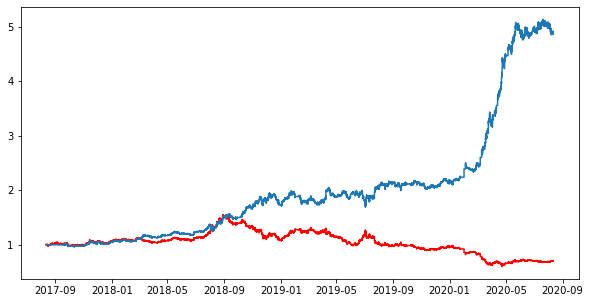

In [17]:
from matplotlib import pyplot as plt
index = 0#选则收集到的公式树表中的第几个公式树
individual = hof[index][0] #
print(str(individual))
func = toolbox.compile(expr=individual)
signal = func(data['open'],data['close'],data['high'],data['low'],data['volume'], data['position'])
ret_lst, exchange, time= feature_to_strategy(signal, data)
plt.figure(figsize=(10,5))
plt.plot(pd.to_datetime(data['DateTime']),(1+data['return']).cumprod(), color='red')
plt.plot(pd.to_datetime(data['DateTime']), pd.Series(ret_lst).cumprod())
plt.savefig('C:/Users/rog/Dropbox/gtja/AL_return_MA.png',dpi=100)

In [27]:
a = pd.Series(ret_lst).cumprod()
a.iloc[-1]

4.906391190269928

In [29]:
(4.906391190269928-1)/3

1.3021303967566427

## Maximum Lost

173593
153687
-0.3617426137572246


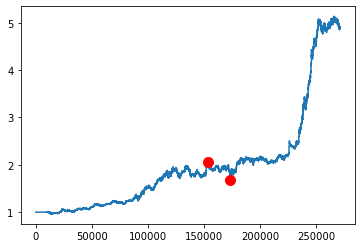

In [26]:

data_to_lot = pd.Series(ret_lst).cumprod()
index_j = np.argmax(np.maximum.accumulate(data_to_lot) - data_to_lot)  # 结束位置
print(index_j)
index_i = np.argmax(data_to_lot[:index_j])  # 开始位置
print(index_i)
d = data_to_lot[index_j] - data_to_lot[index_i]  # 最大回撤
print(d)
 
# 绘制图像

plt.plot(data_to_lot)
plt.plot([index_i, index_j], [data_to_lot[index_i], data_to_lot[index_j]], 'o', color="r", markersize=10)
plt.show()
#plt.savefig('C:/Users/rog/Dropbox/gtja/PTA_return_LINEARREG_SLOPE.png',dpi=100)

In [150]:
time/exchange

4681.945454545455

# Parameter Tuning

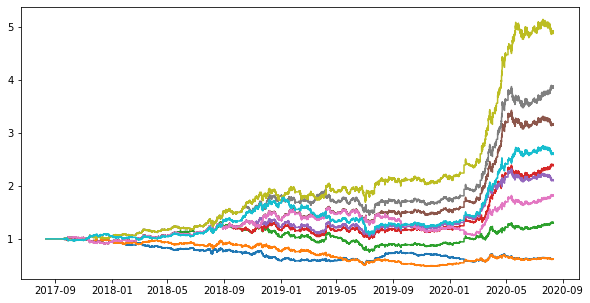

In [35]:
plt.figure(figsize=(10,5))
#plt.plot(pd.to_datetime(data['DateTime']),(1+data['return']).cumprod(), color='red')
for i in range(10):
    signal = MA(ts_std(CCI(225), 7+i*10), 121)
    ret_lst,exchange,time= feature_to_strategy(signal, data)
    to_plot = pd.Series(ret_lst).cumprod()
    plt.plot(pd.to_datetime(data['DateTime']),to_plot)
plt.savefig('C:/Users/rog/Dropbox/gtja/AL_return_bianli_3.png',dpi=100)